In [39]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os
from glob import glob
import shutil
from tqdm import tqdm
import pandas as pd

100%|██████████| 891/891 [00:06<00:00, 139.24it/s]


Train 
WSI(caption) : 891
Patch Image : 236181
Patch Image / WSI (P/W) : 265.074
P/W .std : 246.532


100%|██████████| 100/100 [00:00<00:00, 134.34it/s]


Test 
WSI(caption) : 100
Patch Image : 26596
Patch Image / WSI (P/W) : 265.960
P/W .std : 220.367


100%|██████████| 991/991 [00:07<00:00, 139.31it/s]


Total 
WSI(caption) : 991
Patch Image : 262777
Patch Image / WSI (P/W) : 265.163
P/W .std : 244.019


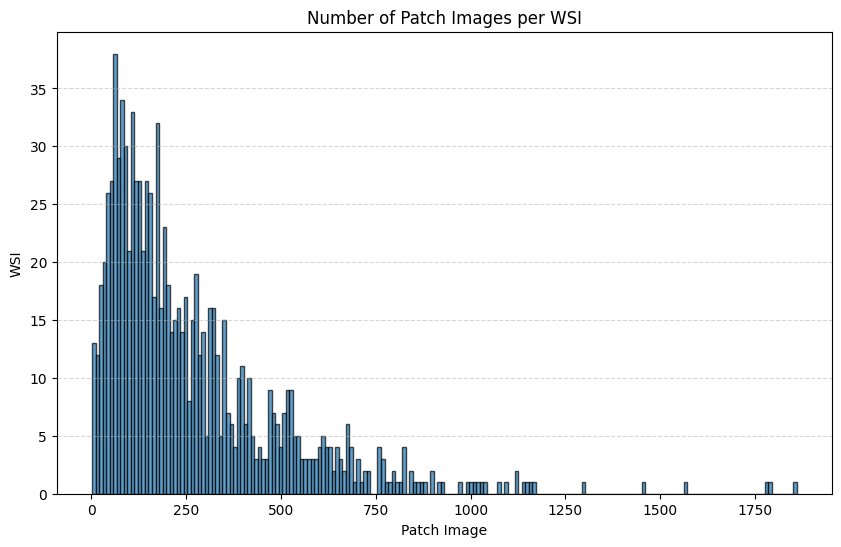

In [54]:
# 내부 데이터 비교

#Train
data_path='../../data/PatchGastricADC22/f_patches_captions/'
train_csv=pd.read_csv('../../data/PatchGastricADC22/train_captions_backup.csv')
Folder_list=[]
folder_len_list=[]
for i in range(len(train_csv)):
    Folder_list.append(data_path+train_csv.loc[i]['id']+'/')
for j in tqdm(range(len(Folder_list))):
    folder_len_list.append(len(glob(Folder_list[j]+'*.jpg')))
folder_len_list = np.array(folder_len_list)     
print(f'Train \nWSI(caption) : {len(Folder_list)}\nPatch Image : {folder_len_list.sum()}\nPatch Image / WSI (P/W) : {folder_len_list.mean():06.3f}\nP/W .std : {np.std(folder_len_list):06.3f}')

#Test
test_csv=pd.read_csv('../../data/PatchGastricADC22/test_captions.csv')
Folder_list=[]
folder_len_list=[]
for i in range(len(test_csv)):
    Folder_list.append(data_path+test_csv.loc[i]['id']+'/')
for j in tqdm(range(len(Folder_list))):
    folder_len_list.append(len(glob(Folder_list[j]+'*.jpg')))
folder_len_list = np.array(folder_len_list)     
print(f'Test \nWSI(caption) : {len(Folder_list)}\nPatch Image : {folder_len_list.sum()}\nPatch Image / WSI (P/W) : {folder_len_list.mean():06.3f}\nP/W .std : {np.std(folder_len_list):06.3f}')

#Total
Folder_list=glob(data_path+'**/')
folder_len_list = []
for i in tqdm(range(len(Folder_list))):
    folder_len_list.append(len(glob(Folder_list[i]+'*.jpg')))
folder_len_list = np.array(folder_len_list)
print(f'Total \nWSI(caption) : {len(Folder_list)}\nPatch Image : {folder_len_list.sum()}\nPatch Image / WSI (P/W) : {folder_len_list.mean():06.3f}\nP/W .std : {np.std(folder_len_list):06.3f}')
plt.figure(figsize=(10, 6))
plt.hist(folder_len_list, bins=200, edgecolor='black', alpha=0.7)
plt.title('Number of Patch Images per WSI')
plt.xlabel('Patch Image')
plt.ylabel('WSI')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

In [57]:
folder_len_list.min()

np.int64(2)